In [1]:
# %matplotlib inline
# %matplotlib widget
# %matplotlib notebook

import warnings
warnings.filterwarnings(action='ignore')

import os
import numpy as np
import tensorflow as tf
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Circle
import seaborn as sns
from  matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R3d
import imageio
import time
import importlib
import glob
from scipy.ndimage import gaussian_filter
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics
from scipy.spatial import distance_matrix,distance
from scipy.cluster import hierarchy
from scipy.optimize import minimize
from scipy import linalg

import dynamics_3d as dn3d
import animation_generation as angn
import optical_signal as opsg
import predefined_weights as pdwt
import samples_generation as smgn
import flow_field as flfd
import lplc2_models as lplc2
import helper_functions as hpfn
import helper_functions_baohua as hpfnbz

In [4]:
figure_path = '../results/FiguresForPaper/final/hessian/'
if not os.path.exists(figure_path):
    os.mkdir(figure_path)

# Loss function, gradient and Hessian

## Analytical solution

In [5]:
def get_gradient_hessian_one_sample(y,UV_flow_rot,P,P_T,Ie_T,Ii_T,Wi,bi,be):
    '''
    y: scaler
    P: scaler
    P_T: an array of P with length T
    Ie_T: T by Q
    Ii_T: T by Q
    bi: scaler
    be: scaler
    UV_flow_rot: T by Q by K*K by 4
    Wi: K*K
    '''
    T = len(P_T)
    
    # Useful derivatives
    dl_dP = -y/P+(1-y)/(1-P) # scaler
    dl_dP_2 = y/(P**2)+(1-y)/((1-P)**2) # scaler
    dP_dRt_T = 1/T*np.multiply(P_T,1-P_T) # T
    dP_dRt_T_2 = 1/T*np.multiply(np.multiply(P_T,1-P_T),1-2*P_T) # T
    dP_db = dP_dRt_T.sum() # scaler
    dP_db_2 = dP_dRt_T_2.sum() # scaler
    dRt_dbe_T = np.heaviside(Ie_T-Ii_T+be,0).sum(axis=1) # T
    dRt_dIi_T = -np.heaviside(Ie_T-Ii_T+be,0) # T by Q
    dRt_dIe_T = np.heaviside(Ie_T-Ii_T+be,0) # T by Q
    dIi_dbi = np.heaviside(np.dot(UV_flow_rot[:,:,:,0],Wi)+bi,0) \
            + np.heaviside(np.dot(UV_flow_rot[:,:,:,1],Wi)+bi,0) \
            + np.heaviside(np.dot(UV_flow_rot[:,:,:,2],Wi)+bi,0) \
            + np.heaviside(np.dot(UV_flow_rot[:,:,:,3],Wi)+bi,0) # T by Q
    dIe_dWe = UV_flow_rot.sum(axis=-1) # T by Q by K*K
    dIi_dWi = np.multiply(np.heaviside(np.dot(UV_flow_rot[:,:,:,0],Wi)+bi,0).reshape(T,Q,1),UV_flow_rot[:,:,:,0]) \
            + np.multiply(np.heaviside(np.dot(UV_flow_rot[:,:,:,1],Wi)+bi,0).reshape(T,Q,1),UV_flow_rot[:,:,:,1]) \
            + np.multiply(np.heaviside(np.dot(UV_flow_rot[:,:,:,2],Wi)+bi,0).reshape(T,Q,1),UV_flow_rot[:,:,:,2]) \
            + np.multiply(np.heaviside(np.dot(UV_flow_rot[:,:,:,3],Wi)+bi,0).reshape(T,Q,1),UV_flow_rot[:,:,:,3]) # T by Q by K*K
    dRt_dbi_T = np.multiply(dRt_dIi_T,dIi_dbi).sum(axis=1) # T
    dRt_dWe_T = np.multiply(dRt_dIe_T.reshape(T,Q,1),dIe_dWe).sum(axis=1) # T by K*K
    dRt_dWi_T = np.multiply(dRt_dIi_T.reshape(T,Q,1),dIi_dWi).sum(axis=1) # T by K*K
    dP_dbe = np.dot(dP_dRt_T,dRt_dbe_T) # scaler
    dP_dbi = np.dot(dP_dRt_T,dRt_dbi_T) # scaler
    dP_dWe = np.dot(dP_dRt_T,dRt_dWe_T) # K*K
    dP_dWi = np.dot(dP_dRt_T,dRt_dWi_T) # K*K
    
    ###gradient###
    dl_db = dl_dP*dP_db # scaler
    dl_dbe = dl_dP*dP_dbe # scaler
    dl_dbi = dl_dP*dP_dbi # scaler
    dl_dWe = dl_dP*dP_dWe # K*K
    dl_dWi = dl_dP*dP_dWi # K*K
    dl_dtheta = np.concatenate(([dl_db],[dl_dbe],[dl_dbi],dl_dWe[:72],dl_dWi[:72]))
    
    ###Hessian###
    dP_dtheta = np.concatenate(([dP_db],[dP_dbe],[dP_dbi],\
                                dP_dWe[4:8],dP_dWe[14:22],dP_dWe[25:35],dP_dWe[37:47],dP_dWe[48:72],\
                                dP_dWi[4:8],dP_dWi[14:22],dP_dWi[25:35],dP_dWi[37:47],dP_dWi[48:72]))
    dRt_dtheta = np.concatenate(([[1]],[dRt_dbe_T],[dRt_dbi_T],\
                                 dRt_dWe_T[:,4:8],dRt_dWe_T[:,14:22],dRt_dWe_T[:,25:35],dRt_dWe_T[:,37:47],dRt_dWe_T[:,48:72],\
                                 dRt_dWi_T[:,4:8],dRt_dWi_T[:,14:22],dRt_dWi_T[:,25:35],dRt_dWi_T[:,37:47],dRt_dWi_T[:,48:72]),axis=1)
    dl_dtheta_2 = dl_dP_2*np.outer(dP_dtheta,dP_dtheta) \
             + dl_dP*dP_dRt_T_2*np.outer(dRt_dtheta,dRt_dtheta)

    return dl_dtheta, dl_dtheta_2
    
    
def get_gradient_hessian_all(yr,Xr_rot,P_all,P_T_all,Ie_T_all,Ii_T_all,Wi,bi,be):
    N = len(yr)
    dl_dtheta_a = 0
    dl_dtheta_2_a = 0
    for n in range(N):
        y = yr[n]
        UV_flow_rot = Xr_rot[n:n+1]
        P = P_all[n]
        P_T = P_T_all[n]
        Ie_T = Ie_T_all[n]
        Ii_T = Ii_T_all[n]
        dl_dtheta, dl_dtheta_2 = get_gradient_hessian_one_sample(y,UV_flow_rot,P,P_T,Ie_T,Ii_T,Wi,bi,be)
        
        dl_dtheta_a = dl_dtheta_a + dl_dtheta/N
        dl_dtheta_2_a = dl_dtheta_2_a + dl_dtheta_2/N
        
        
    return dl_dtheta_a, dl_dtheta_2_a
        

In [6]:
importlib.reload(hpfnbz)

in_or_out = 1 # 0: outward; 1: inward
if in_or_out == 0:
    gradient_all_outward = []
    hessian_all_outward = []
    weights_e_all_outward = []
    weights_i_all_outward = []
else:
    gradient_all_inward = []
    hessian_all_inward = []
    weights_e_all_inward = []
    weights_i_all_inward = []

Qs = [1,2,4,8,16,32,64,128,256]
for Q in Qs:
    K = 12
    L = 4
    KK = K**2
    pad = 2*L
    NNs = 10

    # load data
    data_file = '/Volumes/Baohua/data_on_hd/loom/multi_lplc2_scal200_D5/set_{}/training/train_flow_samples.npy'.format(np.int(1000+Q))
    label_file = '/Volumes/Baohua/data_on_hd/loom/multi_lplc2_scal200_D5/set_{}/training/train_labels_samples.npy'.format(np.int(1000+Q))

    X = np.load(data_file)
    y = np.load(label_file)

    Xr = X.reshape((4000,Q,144,4))
    yr = y.reshape((4000))

    # rotate the stimuli
    Xr_2 = Xr.reshape((4000,Q,12,12,4))
    Xr_2_rot = np.zeros_like(Xr_2)
    Xr_2_rot[:,:,:,:,0] = Xr_2[:,:,:,:,0]
    Xr_2_rot[:,:,:,:,1] = np.rot90(Xr_2[:,:,:,:,1],k=2,axes=(2,3))
    Xr_2_rot[:,:,:,:,2] = np.rot90(Xr_2[:,:,:,:,2],k=3,axes=(2,3))
    Xr_2_rot[:,:,:,:,3] = np.rot90(Xr_2[:,:,:,:,3],k=1,axes=(2,3))
    Xr_rot = Xr_2_rot.reshape((4000,Q,144,4))


    data_path = '../results/FiguresForPaper/model_clustering_hessian/clusterings/'
    model_folders = np.load(data_path+'model_folders_Q{}.npy'.format(Q),allow_pickle=True)
    
    args = {}
    args["n"] = 0
    args["dt"] = 0.01
    args["use_intensity"] = False
    args["symmetrize"] = True
    args['K'] = K
    args['alpha_leak'] = 0.0
    args['Q'] = Q
    args['temporal_filter'] = False
    args['tau_1'] = 1.

    model_path = model_folders[in_or_out][5]+'/'
    a = np.load(model_path + "trained_a.npy")
    b = np.load(model_path + "trained_b.npy")  
    intercept_e = np.load(model_path + "trained_intercept_e.npy")
    weights_e = np.load(model_path + "trained_weights_e.npy")
    weights_i = np.load(model_path + "trained_weights_i.npy")
    intercept_i = np.load(model_path + "trained_intercept_i.npy")
    regu_l2 = 1e-4

    loss,probability_all,probability_T_all,res_T_all,Ie_T_all,Ii_T_all = hpfnbz.get_loss(args,a,b,weights_e,weights_i,intercept_e,intercept_i,Xr,yr,regu_l2)
    print(Q,loss)

    P_all = probability_all
    P_T_all = probability_T_all
    Wi = weights_i[:,0]
    bi = intercept_i
    be = intercept_e

    dl_dtheta_a, dl_dtheta_2_a = get_gradient_hessian_all(yr,Xr_rot,P_all,P_T_all,Ie_T_all,Ii_T_all,Wi,bi,be)
    
    if in_or_out == 0:
        gradient_all_outward.append(dl_dtheta_a)
        hessian_all_outward.append(dl_dtheta_2_a)
        weights_e_all_outward.append(weights_e[:72,0])
        weights_i_all_outward.append(weights_i[:72,0])
    else:
        gradient_all_inward.append(dl_dtheta_a)
        hessian_all_inward.append(dl_dtheta_2_a)
        weights_e_all_inward.append(weights_e[:72,0])
        weights_i_all_inward.append(weights_i[:72,0])
    
if in_or_out == 0:
    filename = figure_path+'gradient_all_outward'
    np.save(filename,gradient_all_outward)
    filename = figure_path+'hessian_all_outward'
    np.save(filename,hessian_all_outward)
    filename = figure_path+'weights_e_all_outward'
    np.save(filename,weights_e_all_outward)
    filename = figure_path+'weights_i_all_outward'
    np.save(filename,weights_i_all_outward)
else:
    filename = figure_path+'gradient_all_inward'
    np.save(filename,gradient_all_inward)
    filename = figure_path+'hessian_all_inward'
    np.save(filename,hessian_all_inward)
    filename = figure_path+'weights_e_all_inward'
    np.save(filename,weights_e_all_inward)
    filename = figure_path+'weights_i_all_inward'
    np.save(filename,weights_i_all_inward)

1 0.4664118637409813
2 0.4394623383526597
4 0.3934155395270167
8 0.3520803753172929
16 0.32347749252993613
32 0.26507379272574616
64 0.21455700993226054
128 0.16106929662829475
256 0.2085926626275847


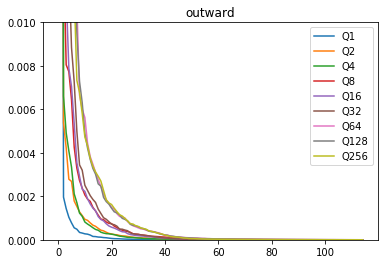

In [41]:
hessian_all_outward = np.load(figure_path+'hessian_all_outward.npy')
Qs = [1,2,4,8,16,32,64,128,256]
for hessian in hessian_all_outward:
    eig_Q = linalg.eigvalsh(hessian)
    plt.plot(np.flip(eig_Q))
#     plt.yscale('log')
    plt.ylim([0,0.01])
    plt.legend(['Q{}'.format(Q) for Q in Qs])
    plt.title('outward')
plt.show()

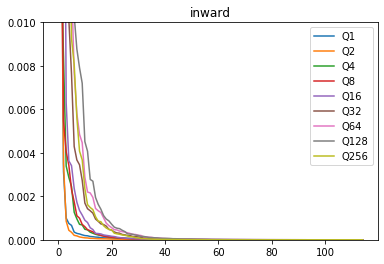

In [40]:
hessian_all_inward = np.load(figure_path+'hessian_all_inward.npy')
for hessian in hessian_all_inward:
    eig_Q = linalg.eigvalsh(hessian)
    plt.plot(np.flip(eig_Q))
#     plt.yscale('log')
    plt.ylim([0,0.01])
    plt.legend(['Q{}'.format(Q) for Q in Qs])
    plt.title('inward')
plt.show()

In [21]:
eig256 = linalg.eigvalsh(hessian_all_inward[-2])

In [22]:
eig256

array([1.74970361e-07, 2.07688279e-07, 2.28712163e-07, 2.66200654e-07,
       3.75445211e-07, 4.14153149e-07, 4.50969452e-07, 4.91578489e-07,
       5.51896977e-07, 6.37817428e-07, 6.93898778e-07, 7.06900134e-07,
       7.87680639e-07, 8.88141748e-07, 1.13187891e-06, 1.22368686e-06,
       1.44474986e-06, 1.56303709e-06, 1.65383692e-06, 1.95100202e-06,
       2.22463509e-06, 2.48133986e-06, 2.82676077e-06, 3.30362190e-06,
       3.35553641e-06, 3.69817897e-06, 3.83487813e-06, 4.12099731e-06,
       4.55928207e-06, 4.77548840e-06, 4.82193177e-06, 4.93872513e-06,
       5.24922415e-06, 5.61393641e-06, 5.83887486e-06, 5.95236679e-06,
       6.25347895e-06, 6.73049298e-06, 6.99547865e-06, 7.69203914e-06,
       7.96060975e-06, 8.07745608e-06, 9.17917928e-06, 9.60437418e-06,
       1.00517550e-05, 1.05619346e-05, 1.09537048e-05, 1.15698011e-05,
       1.16487570e-05, 1.26099082e-05, 1.41546595e-05, 1.50678163e-05,
       1.56723224e-05, 1.70430363e-05, 1.86898920e-05, 1.87316277e-05,
      

In [36]:
minus_log_fisher_info_outward = []
minus_log_fisher_info_inward = []
for ind, Q in enumerate(Qs):
    mlfi = -np.sum(np.log10(linalg.eigvalsh(hessian_all_outward[ind])[-30:]))
    minus_log_fisher_info_outward.append(mlfi)
    mlfi = -np.sum(np.log10(linalg.eigvalsh(hessian_all_inward[ind])[-30:]))
    minus_log_fisher_info_inward.append(mlfi)

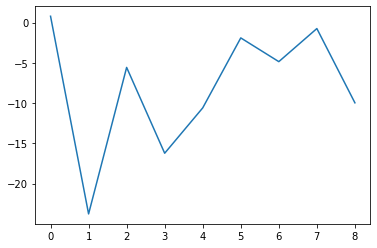

In [37]:
plt.plot(np.array(minus_log_fisher_info_outward)-np.array(minus_log_fisher_info_inward))
plt.show()

## Tensorflow

In [5]:
importlib.reload(hpfnbz)

in_or_out = 1 # 0: outward; 1: inward
if in_or_out == 0:
    gradient_all_outward_tf = []
    hessian_all_outward_tf = []
else:
    gradient_all_inward_tf = []
    hessian_all_inward_tf = []

Qs = [1,2,4,8,16,32,64,128,256]
for Q in Qs:
    # parameters that need to be changed
    args = {}
    args["Q"] = Q
    args["restrict_nonneg_weight"] = True
    args['save_folder'] = 'multi_lplc2_training_D5_i2_4'
    args["data_path"] = '../../data/loom/multi_lplc2_scal200_D5_4/'

    # define parameters for model training that are not frequently changed
    args["set_number"] = np.int(1000+args['Q'])
    args["N_epochs"] = 2000
    args['rotational_fraction'] = 1.0
    args["n"] = 1
    args["dt"] = 0.01
    args["K"] = 12 
    args["L"] = 4
    args["lr"] = 1e-3
    args["frames_to_remove"] = 0
    args['restrict_nonpos_intercept'] = False
    args["rotation_symmetry"] = True
    args["flip_symmetry"] = True
    args["use_intensity"] = False
    args["train_a"] = False
    args["report_num"] = 400 
    args["max_response"] = False
    args["temporal_filter"] = False
    args["learn_tau"] = False
    args["tau"] = 2.0 # 0->1s, 1->368ms, 2-> 135ms, 3->50 ms,  4->18ms
    args["activation"] = 0 # 0 is ReLU, 1 is Leaky ReLU, 2 is ELU, 3 is tanh
    args["leaky_relu_constant"] = 0.02
    args["square_activation"] = False 
    args["fine_tune_weights"] = False
    args["fine_tune_intercepts_and_b"] = False
    args["fine_tune_model_dir"] = "hand_tuned_weights/inhibitory2/" 
    args["save_intermediate_weights"] = False
    args["save_steps"] = 5000
    args["use_step_weight"] = False
    args["l1_regu_we"] = 0.
    args["l1_regu_wi"] = 0.
    args["l1_regu_a"] = 0.
    args["l2_regu_we"] = 1e-4
    args["l2_regu_wi"] = 1e-4
    args["l2_regu_a"] = 0.
    args['NNs'] = 10
    args['M'] = 5

    data_path = '../results/FiguresForPaper/model_clustering/clusterings/'
    model_folders = np.load(data_path+'model_folders_Q{}.npy'.format(Q),allow_pickle=True)
    model_path = model_folders[in_or_out][5]+'/'
    a = np.load(model_path + "trained_a.npy")
    b = np.load(model_path + "trained_b.npy")  
    intercept_e = np.load(model_path + "trained_intercept_e.npy")
    weights_e = np.load(model_path + "trained_weights_e.npy")
    weights_i = np.load(model_path + "trained_weights_i.npy")
    intercept_i = np.load(model_path + "trained_intercept_i.npy")
    
    # load data
    data_file = '/Volumes/Baohua/data_on_hd/loom/multi_lplc2_scal200_D5_5/set_{}/training/train_flow_samples.npy'.format(np.int(1000+Q))
    label_file = '/Volumes/Baohua/data_on_hd/loom/multi_lplc2_scal200_D5_5/set_{}/training/train_labels_samples.npy'.format(np.int(1000+Q))

    X = np.load(data_file)
    y = np.load(label_file)

    Xr = X.reshape((4000,Q,144,4))
    yr = y.reshape((4000))

    train_flow_samples_r = Xr.reshape((1,4000,Q,144,4))
    train_labels_samples_r = yr.reshape((1,4000))
    parameters_in = np.zeros(147,dtype=np.float32)
    parameters_in[0] = b
    parameters_in[1] = intercept_e
    parameters_in[2] = intercept_i
    parameters_in[3:75] = weights_e[:72,0]
    parameters_in[75:147]= weights_i[:72,0]


    loss_res,grad_res,weights_e_out,weights_i_out = \
        hpfnbz.get_gradient_hessian(args,train_flow_samples_r,train_labels_samples_r,parameters_in)
    print(Q,loss_res,in_or_out)
    
    if in_or_out == 0:
        gradient_all_outward_tf.append(grad_res)
    else:
        gradient_all_inward_tf.append(grad_res)

if in_or_out == 0: 
    filename = figure_path+'gradient_all_outward_tf'
    np.save(filename,gradient_all_outward_tf)
else:      
    filename = figure_path+'gradient_all_inward_tf'
    np.save(filename,gradient_all_inward_tf)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
1 0.474419 1
INFO:tensorflow:Scale of 0 disables regularizer.
2 0.4328223 1
INFO:tensorflow:Scale of 0 disables regularizer.
4 0.3983361 1
INFO:tensorflow:Scale of 0 disables regularizer.
8 0.3490287 1
INFO:tensorflow:Scale of 0 disables regularizer.
16 0.31440955 1
INFO:tensorflow:Scale of 0 disables regularizer.
32 0.26965606 1
INFO:tensorflow:Scale of 0 disables regularizer.
64 0.23505166 1
INFO:tensorflow:Scale of 0 disables regularizer.
128 0.2224533 1
INFO:tensorflow:Scale of 0 disa

## Scipy

In [15]:
importlib.reload(hpfnbz)

fun = hpfnbz.get_loss_for_training

in_or_out = 1 # 0: outward; 1: inward
if in_or_out == 0:
    gradient_all_outward_sp = []
    hessian_all_outward_sp = []
else:
    gradient_all_inward_sp = []
    hessian_all_inward_sp = []

Qs = [1,2,4,8,16]
for Q in Qs:
    # parameters that need to be changed
    args = {}
    args["Q"] = Q
    args["restrict_nonneg_weight"] = True
    args['save_folder'] = 'multi_lplc2_training_D5_i2'
    args["data_path"] = '../../data/loom/multi_lplc2_scal200_D5/'

    # define parameters for model training that are not frequently changed
    args["set_number"] = np.int(1000+args['Q'])
    args["N_epochs"] = 2000
    args['rotational_fraction'] = 1.0
    args["n"] = 1
    args["dt"] = 0.01
    args["K"] = 12 
    args["L"] = 4
    args["lr"] = 1e-3
    args["frames_to_remove"] = 0
    args['restrict_nonpos_intercept'] = False
    args["rotation_symmetry"] = True
    args["flip_symmetry"] = True
    args["use_intensity"] = False
    args["train_a"] = False
    args["report_num"] = 400 
    args["max_response"] = False
    args["temporal_filter"] = False
    args["learn_tau"] = False
    args["tau_1"] = 2.0 # 0->1s, 1->368ms, 2-> 135ms, 3->50 ms,  4->18ms
    args["activation"] = 0 # 0 is ReLU, 1 is Leaky ReLU, 2 is ELU, 3 is tanh
    args["alpha_leak"] = 0.02
    args["square_activation"] = False 
    args["fine_tune_weights"] = False
    args["fine_tune_intercepts_and_b"] = False
    args["fine_tune_model_dir"] = "hand_tuned_weights/inhibitory2/" 
    args["save_intermediate_weights"] = False
    args["save_steps"] = 5000
    args["use_step_weight"] = False
    args['NNs'] = 10
    args['M'] = 5

    data_path = '../results/FiguresForPaper/model_clustering/clusterings/'
    model_folders = np.load(data_path+'model_folders_Q{}.npy'.format(Q),allow_pickle=True)
    model_path = model_folders[in_or_out][5]+'/'
    a = np.load(model_path + "trained_a.npy")
    b = np.load(model_path + "trained_b.npy")  
    intercept_e = np.load(model_path + "trained_intercept_e.npy")
    weights_e = np.load(model_path + "trained_weights_e.npy")
    weights_i = np.load(model_path + "trained_weights_i.npy")
    intercept_i = np.load(model_path + "trained_intercept_i.npy")
    
    # load data
    data_file = '/Volumes/Baohua/data_on_hd/loom/multi_lplc2_scal200_D5_5/set_{}/training/train_flow_samples.npy'.format(np.int(1000+Q))
    label_file = '/Volumes/Baohua/data_on_hd/loom/multi_lplc2_scal200_D5_5/set_{}/training/train_labels_samples.npy'.format(np.int(1000+Q))

    X = np.load(data_file)
    y = np.load(label_file)

    Xr = X.reshape((4000,Q,144,4))
    yr = y.reshape((4000))

    train_flow_samples_r = Xr.reshape((1,4000,Q,144,4))
    train_labels_samples_r = yr.reshape((1,4000))
    parameters_in = np.zeros(147,dtype=np.float32)
    parameters_in[0] = b
    parameters_in[1] = intercept_e
    parameters_in[2] = intercept_i
    parameters_in[3:75] = weights_e[:72,0]
    parameters_in[75:147]= weights_i[:72,0]

    x0 = parameters_in
    regu_l2 = 1e-4
    options={'maxiter': 1}
    bnds = ((None,None),(None,None),(None,None))
    for ii in range(144):
        bnds = bnds + ((0,None),)
    res = minimize(fun, x0, args=(args,Xr,yr,regu_l2), \
                   method='BFGS', \
                   jac=None, \
                   hess=None, \
                   bounds=bnds, \
                   options=options)
    print(Q,res.fun,in_or_out)
    
    if in_or_out == 0:
        gradient_all_outward_sp.append(res.jac)
    else:
        gradient_all_inward_sp.append(res.jac)
        
if in_or_out == 0:
    filename = figure_path+'gradient_all_outward_sp'
    np.save(filename,gradient_all_outward_sp)
else:
    filename = figure_path+'gradient_all_inward_sp'
    np.save(filename,gradient_all_inward_sp)

1 0.47629567295473385 1
2 0.4379487473222912 1
4 0.4067031057836671 1
8 0.35883642301780716 1
16 0.32404363071801645 1


## Plot the results

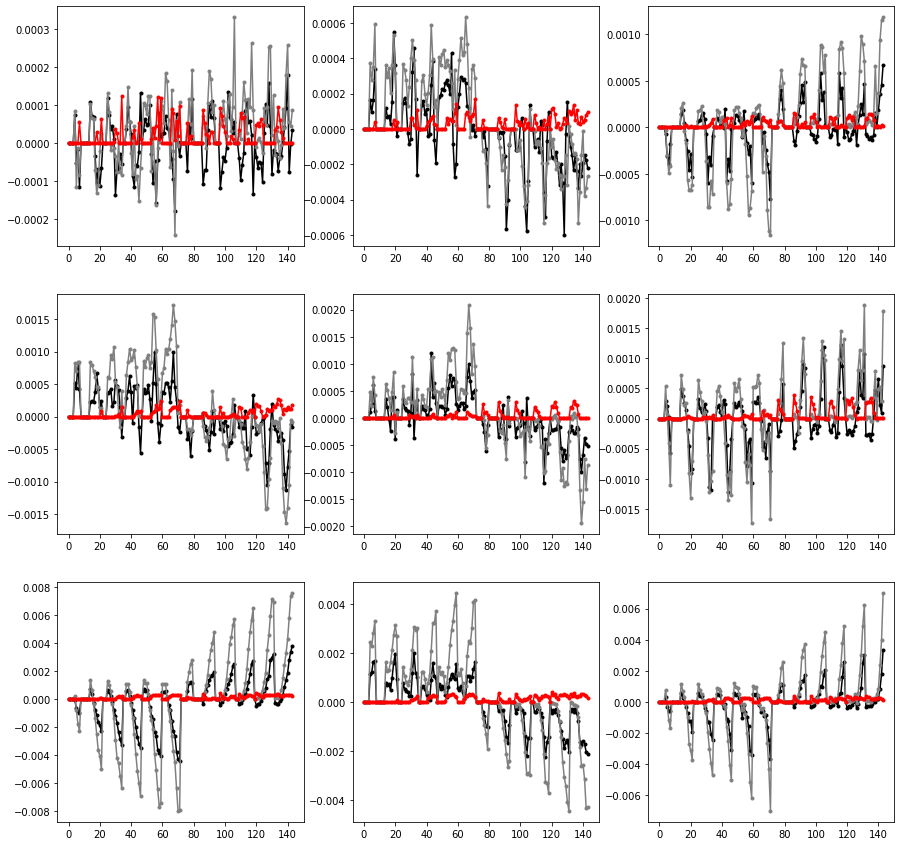

In [8]:
gradient_all_outward = np.load(figure_path+'gradient_all_outward.npy')
gradient_all_outward_tf = np.load(figure_path+'gradient_all_outward_tf.npy')
# gradient_all_outward_sp = np.load(figure_path+'gradient_all_outward_sp.npy')
weights_e_all_outward = np.load(figure_path+'weights_e_all_outward.npy')
weights_i_all_outward = np.load(figure_path+'weights_i_all_outward.npy')
fig, axes = plt.subplots(3,3,figsize=(15,15))
kk = 0
for ii in range(3):
    for jj in range(3):
        weights = np.concatenate((weights_e_all_outward[kk],weights_i_all_outward[kk]))
        axes[ii,jj].plot(gradient_all_outward[kk][3:],marker='.',c='k')
        axes[ii,jj].plot(gradient_all_outward_tf[kk][3:],marker='.',c=[0.5,0.5,0.5])
        axes[ii,jj].plot(weights/10000.,marker='.',c='r')
        kk = kk+1
#         axes[ii,jj].ylim([-0.00001,0.00001])
plt.show()

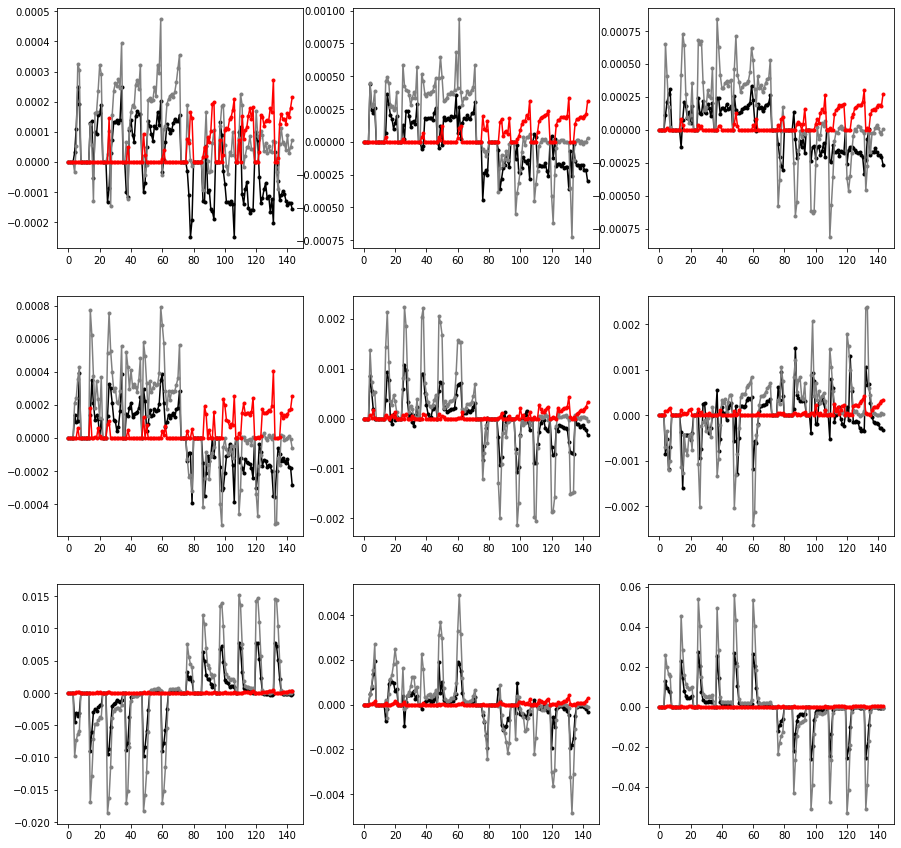

In [10]:
gradient_all_inward = np.load(figure_path+'gradient_all_inward.npy')
gradient_all_inward_tf = np.load(figure_path+'gradient_all_inward_tf.npy')
# gradient_all_inward_sp = np.load(figure_path+'gradient_all_inward_sp.npy')
weights_e_all_inward = np.load(figure_path+'weights_e_all_inward.npy')
weights_i_all_inward = np.load(figure_path+'weights_i_all_inward.npy')
fig, axes = plt.subplots(3,3,figsize=(15,15))
kk = 0
for ii in range(3):
    for jj in range(3):
        weights = np.concatenate((weights_e_all_inward[kk],weights_i_all_inward[kk]))
        axes[ii,jj].plot(gradient_all_inward[kk][3:],marker='.',c='k')
        axes[ii,jj].plot(gradient_all_inward_tf[kk][3:],marker='.',c=[0.5,0.5,0.5])
        axes[ii,jj].plot(weights/10000.,marker='.',c='r')
        kk = kk+1
#         axes[ii,jj].ylim([-0.00001,0.00001])
plt.show()